This notebook was ceated by Ferran Oliver Gerones, Mateusz Zbigniew Zalewski and Nursultan Sheishekeyev for a special course at DTU.

In [1]:
#Loading the library
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

#Loading the dataset and checking the shape
cstr=np.load("cstr_rawdata.npy",)
cstr.shape

(2860, 1404)

# Exploring the CSTR Dataset

## Description

CSTR Domain Adaptation and Fault Diagnosis, available at: https://www.kaggle.com/datasets/eddardd/continuous-stirred-tank-reactor-domain-adaptation/data. Here the goal is to predict a set of 12 faults from the given variables (multi-class classification problem).

Saving it as an excel file for a different exploration


In [2]:
## save to xlsx file

# filepath = 'CSTR_data_3.xlsx'

# df.to_excel(filepath, index=False)

In [3]:
cstr_df = pd.DataFrame(cstr) #converting it to Panda
cstr_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403
0,0.999719,0.999854,1.000517,0.999764,0.999982,1.000978,1.000314,0.999953,0.999051,1.000165,...,10.097724,10.042699,9.963228,10.084302,10.548740,10.032248,0.0,0.0,0.0,1.0
1,1.002411,1.000820,1.001000,0.999042,0.999200,1.001231,1.001470,1.001782,0.999543,0.999201,...,9.731097,10.080027,9.896257,9.088898,9.798987,10.418807,0.0,0.0,0.0,1.0
2,0.999197,0.998922,1.000095,0.999389,0.999128,0.999978,0.999889,1.001926,1.000072,0.999326,...,10.041097,9.745254,10.877219,9.592610,10.046595,10.262627,0.0,0.0,0.0,1.0
3,1.000770,1.000499,0.999830,1.000854,1.001071,1.001708,0.999969,0.998799,1.000446,0.999382,...,10.570380,9.610376,10.546058,10.679968,10.282365,10.035451,0.0,0.0,0.0,1.0
4,1.001674,1.000058,0.999202,0.998686,0.999539,0.999194,1.000795,1.000007,0.999421,1.000157,...,9.787158,9.954904,10.416254,9.866833,10.053383,10.025643,0.0,0.0,0.0,1.0
5,1.000282,1.000683,1.000775,0.999078,0.999441,0.998551,0.999871,1.000402,1.001595,1.001099,...,10.258771,10.165729,9.980313,9.941368,10.604471,10.201198,0.0,0.0,0.0,1.0
6,1.001033,0.999388,1.000021,1.001056,1.000141,0.999230,0.998549,1.000168,1.000862,0.998049,...,8.938734,10.020908,9.940908,10.498017,10.167567,9.901859,0.0,0.0,0.0,1.0
7,1.000780,0.999357,0.997187,0.998834,0.999885,1.001322,1.000881,0.998984,0.999225,1.000534,...,9.276363,9.974554,10.206660,10.323086,9.497744,9.243785,0.0,0.0,0.0,1.0
8,1.000697,0.999358,1.000796,0.999323,1.001705,0.999389,1.001015,1.000195,0.998605,1.000523,...,9.508935,9.119742,10.118859,9.820271,9.414832,10.377239,0.0,0.0,0.0,1.0
9,1.001959,1.000248,0.998432,0.999776,1.002489,1.000801,0.998757,1.000301,0.999964,0.999879,...,10.306115,9.985813,9.720012,10.263209,10.390713,10.076998,0.0,0.0,0.0,1.0


If we take a look to the dataset we can see that the last 4 column don't contain data. These columns give us information about the working operation of the reactor and the reaction taking place.

Column 1400 refers to the Fault.
Column 1401 refers to the domain level
Column 1402 refers to the noise level
Column 1403 refers to the reaction order


In [4]:
test=cstr[:,: -4] #just testing how to remove the 4 columns that doesn't contain relevant information
test.shape

(2860, 1400)

In [5]:
#Define labels for the 4 columns 
fault_label = cstr_df.iloc[:, -4]
domain_label = cstr_df.iloc[:, -3]
parameter_noise = cstr_df.iloc[:, -2]
reaction_order = cstr_df.iloc[:, -1]

In [6]:
#checking the unique domains, we confirm there are 6 uniques domains in this dataset and we can see the datapoints on each domain.
np.unique(domain_label, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6.]),
 array([1300,  260,  260,  260,  260,  260,  260], dtype=int64))

In [7]:
np.unique(fault_label, return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 array([220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220],
       dtype=int64))

There's 6 unique domains which are combinations of the other parameters, will be studied later on.

In [8]:
np.unique(parameter_noise, return_counts=True)
# doing the same for the possible values noise can take

(array([0.  , 0.1 , 0.15, 0.2 ]), array([1300,  260, 1040,  260], dtype=int64))

In [9]:
np.unique(reaction_order, return_counts=True)
# possible values reaction order can take

(array([0.5, 1. , 1.5, 2. ]), array([ 260, 2080,  260,  260], dtype=int64))

To study the parameters for each unique domain:

In [10]:
for domain in np.unique(domain_label):
    domain_parameters = np.where(domain_label == domain)[0]
    print(f'The domain {domain} has a noise level of {np.unique(parameter_noise[domain_parameters]).item()} and a reaction order of {np.unique(reaction_order[domain_parameters]).item()}')


The domain 0.0 has a noise level of 0.0 and a reaction order of 1.0
The domain 1.0 has a noise level of 0.1 and a reaction order of 1.0
The domain 2.0 has a noise level of 0.15 and a reaction order of 1.0
The domain 3.0 has a noise level of 0.2 and a reaction order of 1.0
The domain 4.0 has a noise level of 0.15 and a reaction order of 0.5
The domain 5.0 has a noise level of 0.15 and a reaction order of 1.5
The domain 6.0 has a noise level of 0.15 and a reaction order of 2.0


After visualizing and knowing how the data is organized we can start the treatment and training for the model

In [11]:
# extracting the features and target variable from your DataFrame
X_feature = cstr_df.iloc[:, 0:1400] 
y_target = cstr_df.iloc[:, 1400].values
print(y_target)
print(X_feature.shape, y_target.shape)

# splitting the data into training and testing sets. Test size is splitted into 20/80, testing set 20% of the original dataset's samples, and the training set is the 80%.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

[ 0.  0.  0. ... 12. 12. 12.]
(2860, 1400) (2860,)
(2288, 1400) (572, 1400) (2288,) (572,)


In [12]:
# Creating the function to evaluate different models of prediciton

def predictions(classifier, X_train, y_train, X_test, y_test, model_name):
    classifier.fit(X_train, y_train)
    print(classifier.score(X_test, y_test))

    cm = confusion_matrix(classifier.predict(X_test), y_test)
    sns.heatmap(cm, annot=True, cmap='viridis')
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()

Now we use different classifier models to assess our function and model.

Each of these classifiers will be trained on the training data and then evaluated on the testing data to assess their performance. Different performances are expected and results will be tested in function of the score.

In [ ]:
print('LogisticRegression')
predictions(LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test, model_name='Logistic Regression')

# print('DecisionTreeClassifier')
# predictions(DecisionTreeClassifier(random_state=42, max_depth=3), X_train, y_train, X_test, y_test, model_name='Decision Tree Classifier')

print('KNeighborsClassifier')
predictions(KNeighborsClassifier(), X_train.values, y_train, X_test.values, y_test, model_name='K-Neighbors Classifier')

print('SVC')
predictions(SVC(random_state=2207, probability=True), X_train, y_train, X_test, y_test, model_name='SVC')

print('RandomForestClassifier')
predictions(RandomForestClassifier(random_state=0), X_train, y_train, X_test, y_test, model_name='Random Forest Classifier')

print('XGB Classifier')
predictions(XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1), X_train, y_train, X_test, y_test, model_name='XGB Classifier' )


# Standarizing the Dataset

If we have a look at the original dataset, values for the different parameters (concentration, temperature, etc.) are pretty different. For this reason, a standaritzation technique is used to normalize the data to similar standards. It transforms the data in such a way that it has a mean of 0 and a standard deviation of 1.

In [14]:
# Normalize the features using Standard Scaler
cstr_df_standardized = StandardScaler()
cstr_feature_standard = cstr_df_standardized.fit_transform(cstr_df)
cstr_df_standardized = pd.DataFrame(cstr_feature_standard)

# Extract features and target; same procedure as done before. y_target is not standarized and the values are the same ones as before.
X_feature_standardized = cstr_df_standardized.iloc[:, 0:1400]
y_target_standardized = cstr_df.iloc[:, 1400].values

# Print the target values to check if the values are maintained
print(y_target)

# Split the data into training and testing sets. "_s" is added in order not to overwrite the old ones. Same test size is maintainted.
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_feature_standardized, y_target_standardized, test_size=0.2, random_state=1)

# Print the shapes of the training and testing sets
print(X_train_s.shape, X_test_s.shape, y_train_s.shape, y_test_s.shape)


[ 0.  0.  0. ... 12. 12. 12.]
(2288, 1400) (572, 1400) (2288,) (572,)


In [15]:
cstr_df_standardized.shape

(2860, 1404)

Defining again the function for the Normalized dataset. Using the same approach with the confusion matrix but some low score classifier models are tested to see if the performance are improved. RandomTreeClassifier and XGBoost are also tested to see if their score is increased to an even better value.

In [16]:
def predictions_standard(classifier, X_train_s, y_train_s, X_test_s, y_test_s, model_naming):
    classifier.fit(X_train_s, y_train_s)
    print(classifier.score(X_test_s, y_test_s))

    cm = confusion_matrix(classifier.predict(X_test_s), y_test_s)
    sns.heatmap(cm, annot=True, cmap='viridis')
    plt.title(f'Confusion matrix for {model_naming}')
    plt.show()

In [ ]:
print('LogisticRegression')
predictions_standard(LogisticRegression(max_iter=1000), X_train_s, y_train_s, X_test_s, y_test_s, model_naming='Logistic Regression')

SVC
0.8321678321678322


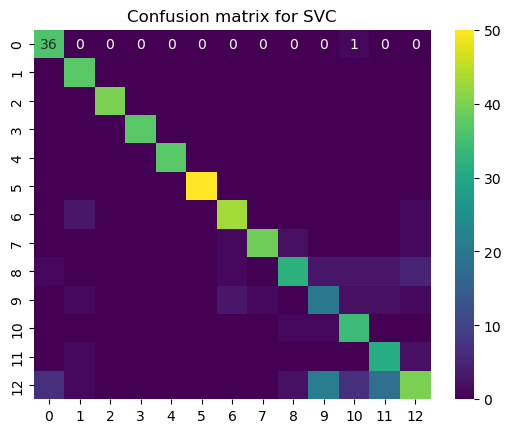

In [18]:
print('SVC')
predictions_standard(SVC(random_state=2207, probability=True), X_train_s, y_train_s, X_test_s, y_test_s, model_naming='SVC')

KNeighborsClassifier
0.8636363636363636


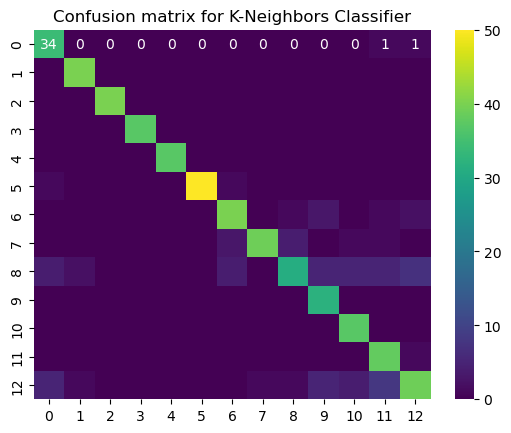

In [19]:
print('KNeighborsClassifier')
predictions_standard(KNeighborsClassifier(), X_train_s.values, y_train_s, X_test_s.values, y_test_s, model_naming= 'K-Neighbors Classifier')

RandomForestClassifier
0.9440559440559441


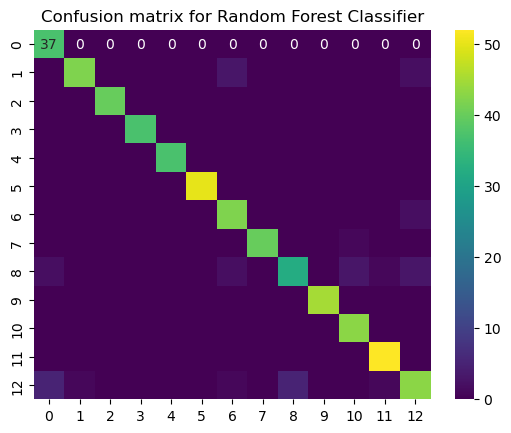

In [20]:
print('RandomForestClassifier')
predictions_standard(RandomForestClassifier(random_state=0), X_train_s, y_train_s, X_test_s, y_test_s, model_naming='Random Forest Classifier')

XGB Classifier
0.9685314685314685


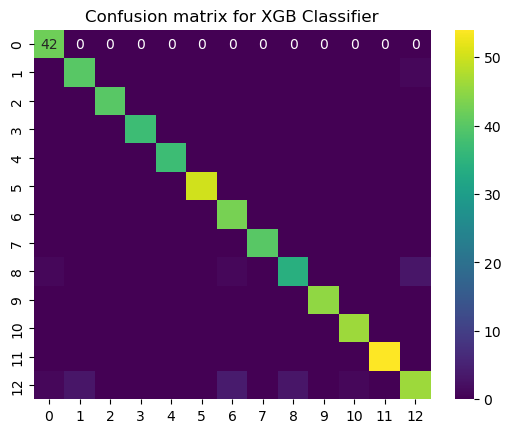

In [21]:
print('XGB Classifier')
predictions_standard(XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.1), X_train_s, y_train_s, X_test_s, y_test_s, model_naming='XGB Classifier' )

# Reducing dimensionality with PCA

In [22]:
pca = PCA()
pca.fit(cstr_df_standardized) #fit the PCA to normalized data

PCA()

Creating a scree plot for for PCA on Xception feature vectors. The scree plot helps visualize the amount of variance explained by each principal component and allows you to identify the number of components that are needed.

We have to choose a threshold of how much of the variance we want to retain. Here we select 95.6% after searching a bit for a total number of data points of 100. Reducing the dimensionality of the vectors helps with the computational time of clustering in the next step.

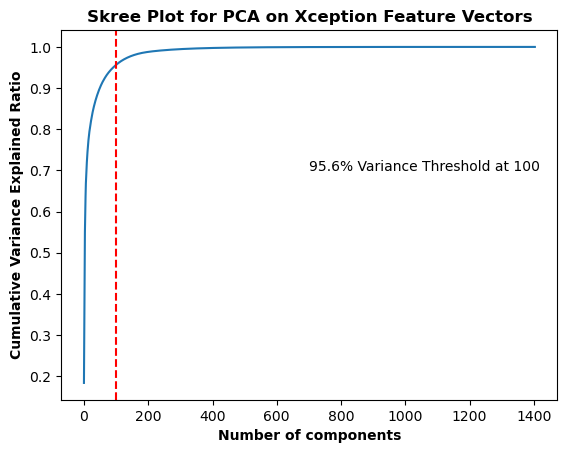

In [23]:
variance_threshold = 0.956

plt.plot([x for x in range(len(pca.explained_variance_))], np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components', fontweight = 'bold')
plt.ylabel('Cumulative Variance Explained Ratio', fontweight = 'bold')
ax = plt.gca()
plt.title('Skree Plot for PCA on Xception Feature Vectors', fontweight = 'bold')
plt.axvline(np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold), linestyle = '--', c = 'red')
plt.text(700,0.7,f'{variance_threshold*100}% Variance Threshold at {np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold)}')
plt.show()

In [24]:
threshold = np.argmax(np.cumsum(pca.explained_variance_ratio_)>variance_threshold) # threshold will contain the index of the variance threshold datapoints.

In [25]:
cstr_pca = pca.transform(cstr_df_standardized)[:, :threshold] #creating and fitting the reduced new dataset. New matrix will have 100 columns instead of 1400.
print(cstr_pca.shape)
print(threshold)

(2860, 100)
100


In [26]:
panda_cstr_pca=pd.DataFrame(cstr_pca) #better overview of the small dataset with pandas
panda_cstr_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,20.024801,-1.265666,-0.866212,-4.621033,-10.468518,-21.584137,-9.755107,-0.314732,0.021163,6.313088,...,-0.142827,-1.598344,2.084111,-0.050554,0.294244,0.578711,-1.006181,0.849879,1.380149,-1.199916
1,19.575499,-1.355723,-0.429885,-4.675771,-9.940136,-21.997233,-10.139352,-0.254733,0.209299,4.867084,...,0.328848,0.805129,0.032803,0.302016,0.868028,1.968735,0.601210,2.827674,-1.667269,-1.745866
2,20.042874,-1.151338,-0.779171,-4.815305,-11.360368,-22.346872,-9.550247,0.053303,-0.275776,0.162458,...,-0.195310,-1.578355,0.583738,0.725218,4.116757,-0.416855,-1.567199,0.795142,0.327243,0.582981
3,21.751458,-1.079057,-0.671385,-4.598306,-13.180756,-23.178427,-9.331301,-0.189524,-0.672218,0.064499,...,-2.574912,-1.103258,3.233107,0.979147,-0.743203,-0.235596,-0.546520,1.253736,0.200573,-1.150531
4,22.348100,-1.095502,-0.712631,-4.653566,-13.417733,-23.765124,-9.929354,-0.137536,-0.751106,0.955516,...,0.141679,1.060190,2.500097,-0.349718,-3.171563,-2.607307,-1.564384,1.952583,0.724768,0.274478


Same process of splitting the data into training and test dataset. This time "_pca" is added to differentiate from the old ones. Same test size is maintained as recommended.

In [27]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(cstr_pca, y_target_standardized, test_size=0.2, random_state=1)

# Print the shapes of the training and testing sets
print(X_train_pca.shape, X_test_pca.shape, y_train_pca.shape, y_test_pca.shape)

(2288, 100) (572, 100) (2288,) (572,)


In [28]:
def predictions_standard_pca(classifier, X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name):
    classifier.fit(X_train_pca, y_train_pca)
    print(classifier.score(X_test_pca, y_test_pca))

    cm = confusion_matrix(classifier.predict(X_test_pca), y_test_pca)
    sns.heatmap(cm, annot=True, cmap='viridis')
    plt.title(f'Confusion matrix for {model_name}')
    plt.show()

In [ ]:
print('LogisticRegression')
predictions_standard_pca(LogisticRegression(max_iter=1000), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='Logistic Regression')

print('RandomForestClassifier')
predictions_standard_pca(RandomForestClassifier(random_state=0), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='Random Forest Classifier')

print('SVC')
predictions_standard_pca(SVC(random_state=2207, probability=True), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='SVC')

print('XGB Classifier')
predictions_standard_pca(XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.1), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='XGB Classifier' )

print('KNeighborsClassifier')
predictions_standard_pca(KNeighborsClassifier(), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name= 'K-Neighbors Classifier')





In [ ]:
print('LogisticRegression')
predictions_standard_pca(LogisticRegression(max_iter=1000), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='Logistic Regression')

print('RandomForestClassifier')
predictions_standard_pca(RandomForestClassifier(random_state=0), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='Random Forest Classifier')

print('XGB Classifier')
predictions_standard_pca(XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.1), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name='XGB Classifier' )

print('KNeighborsClassifier')
predictions_standard_pca(KNeighborsClassifier(), X_train_pca, y_train_pca, X_test_pca, y_test_pca, model_name= 'K-Neighbors Classifier')
